# Hierarchical Clustering with Sentence-BERT (SBERT)
Sentence-BERT 是一种基于预训练语言模型（如 BERT）的特征提取方法。与 TF-IDF 这种基于词频的统计方法不同，SBERT 能够理解句子的深层语义和上下文关系，通常在文本聚类任务中能达到最先进 (State-of-the-Art) 的效果。

**注意**: 运行此 Notebook 需要安装 `sentence-transformers` 库。

In [28]:
# 如果没有安装 sentence-transformers，请取消注释并运行以下代码
# !pip install sentence-transformers

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sentence_transformers import SentenceTransformer

# 1. 读取数据
df = pd.read_csv('../processed_data.csv')
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')
X_train_raw = df['Cleaned_Content'].tolist()

In [30]:
# 2. 特征工程: Sentence-BERT 语义嵌入
# 使用轻量级但效果很好的预训练模型 'all-MiniLM-L6-v2'
model = SentenceTransformer('all-MiniLM-L6-v2')

# 将文本编码为 384 维的稠密向量
print("Encoding text to embeddings... This might take a moment.")
dense_matrix = model.encode(X_train_raw, show_progress_bar=True)

print(f"SBERT Feature Matrix Shape: {dense_matrix.shape}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding text to embeddings... This might take a moment.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

SBERT Feature Matrix Shape: (1000, 384)


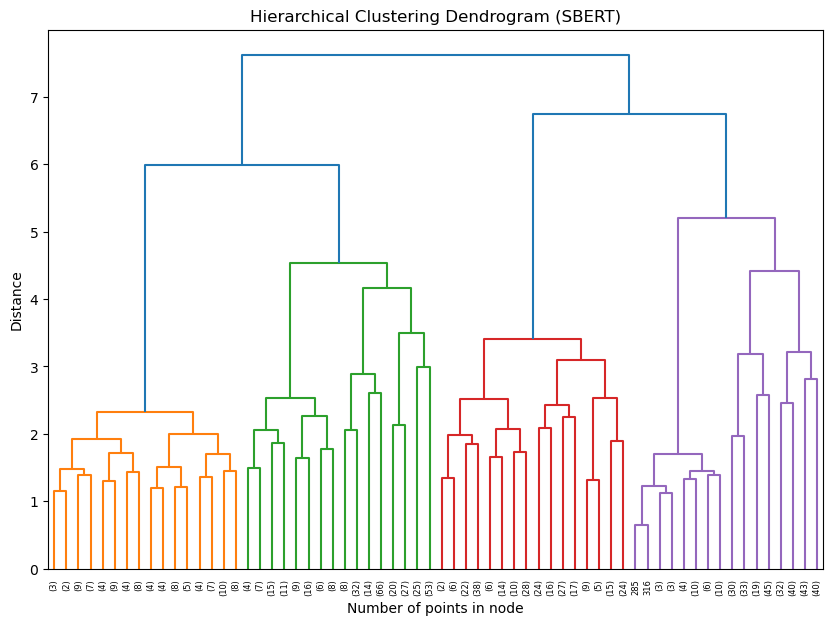

In [31]:
# 3. 层次聚类与树状图
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

# 训练完整树
model_tree = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='ward')
model_tree.fit(dense_matrix)

plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram (SBERT)")
plot_dendrogram(model_tree, truncate_mode='level', p=5)
plt.xlabel("Number of points in node")
plt.ylabel("Distance")
plt.show()

# 提取 5 个簇
max_clusters = 5
model_clusters = AgglomerativeClustering(n_clusters=max_clusters, metric='euclidean', linkage='ward')
clusters = model_clusters.fit_predict(dense_matrix)

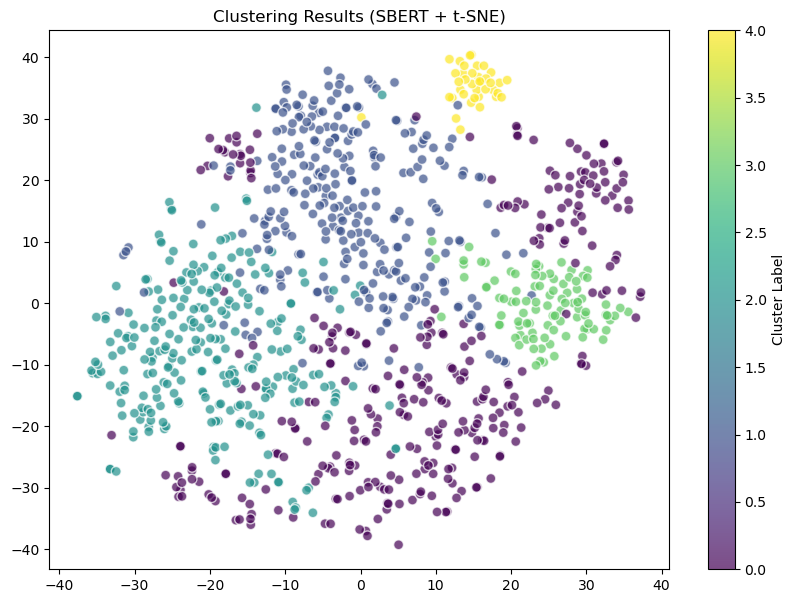

In [32]:
# 4. t-SNE 可视化
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
reduced_features_tsne = tsne.fit_transform(dense_matrix)

plt.figure(figsize=(10, 7))
scatter_tsne = plt.scatter(
    reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], 
    c=clusters, cmap='viridis', alpha=0.7, edgecolors='w', s=50
)
plt.title("Clustering Results (SBERT + t-SNE)")
plt.colorbar(scatter_tsne, label='Cluster Label')
plt.show()

In [33]:
# 5. 评估指标
from sklearn.metrics import cohen_kappa_score, silhouette_score, homogeneity_score, completeness_score
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity

true_labels_text = df['Label'].tolist()
le = LabelEncoder()
true_labels = le.fit_transform(true_labels_text)

def align_labels(true_labels, cluster_labels):
    n_classes = max(len(np.unique(true_labels)), len(np.unique(cluster_labels)))
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, c in zip(true_labels, cluster_labels):
        cm[t, c] += 1
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {c: t for t, c in zip(row_ind, col_ind)}
    return np.array([mapping[c] for c in cluster_labels])

aligned_clusters = align_labels(true_labels, clusters)

kappa = cohen_kappa_score(true_labels, aligned_clusters)
silhouette = silhouette_score(dense_matrix, clusters, metric='euclidean')

# 计算 Coherence (簇内平均余弦相似度)
coherence_scores = []
for cluster_id in np.unique(clusters):
    cluster_points = dense_matrix[clusters == cluster_id]
    if cluster_points.shape[0] > 1:
        sim_matrix = cosine_similarity(cluster_points)
        np.fill_diagonal(sim_matrix, 0)
        avg_sim = sim_matrix.sum() / (cluster_points.shape[0] * (cluster_points.shape[0] - 1))
        coherence_scores.append(avg_sim)
    else:
        coherence_scores.append(1.0)
average_coherence = np.mean(coherence_scores)

homogeneity = homogeneity_score(true_labels, clusters)
completeness = completeness_score(true_labels, clusters)

print("=== SBERT Clustering Evaluation ===")
print(f"Cohen's Kappa:       {kappa:.4f}")
print(f"Silhouette Score:    {silhouette:.4f}")
print(f"Cluster Coherence:   {average_coherence:.4f}")
print(f"Homogeneity Score:   {homogeneity:.4f}")
print(f"Completeness Score:  {completeness:.4f}")

=== SBERT Clustering Evaluation ===
Cohen's Kappa:       0.3313
Silhouette Score:    0.0280
Cluster Coherence:   0.3684
Homogeneity Score:   0.2183
Completeness Score:  0.2471
